In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import norm, uniform
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
np.random.seed(42)

In [3]:
n_auctions = 10000

In [4]:
v1 = np.random.rand(n_auctions)
v2 = np.random.rand(n_auctions)

In [5]:
b1 = v1 / 2
b2 = v2 / 2

In [6]:
bids = np.concatenate([b1, b2])

(array([1.98017189, 2.04917788, 2.06117893, 1.9951732 , 1.8961646 ,
        2.04917788, 1.95316955, 1.98917268, 1.98317216, 1.92916747,
        2.04917788, 2.01617502, 2.11518361, 1.99817346, 1.97117111,
        2.06417919, 2.08218075, 1.98017189, 1.9951732 , 1.91716643,
        2.04917788, 2.00117372, 1.97117111, 1.92016669, 2.02217554,
        1.90516538, 2.11218335, 1.91716643, 2.03717684, 1.9951732 ]),
 array([5.81737768e-06, 1.66710372e-02, 3.33362571e-02, 5.00014770e-02,
        6.66666968e-02, 8.33319167e-02, 9.99971366e-02, 1.16662356e-01,
        1.33327576e-01, 1.49992796e-01, 1.66658016e-01, 1.83323236e-01,
        1.99988456e-01, 2.16653676e-01, 2.33318896e-01, 2.49984115e-01,
        2.66649335e-01, 2.83314555e-01, 2.99979775e-01, 3.16644995e-01,
        3.33310215e-01, 3.49975435e-01, 3.66640654e-01, 3.83305874e-01,
        3.99971094e-01, 4.16636314e-01, 4.33301534e-01, 4.49966754e-01,
        4.66631974e-01, 4.83297194e-01, 4.99962413e-01]),
 <BarContainer object of 30 

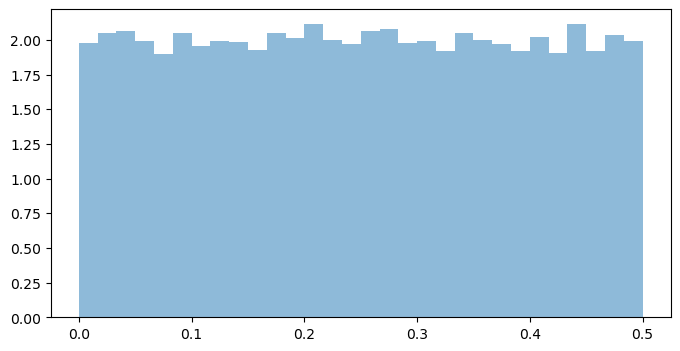

In [7]:
plt.figure(figsize=(8, 4))
plt.hist(bids, bins=30, density=True, alpha=0.5, label='Empirical Bid Distribution')

In [8]:
def kde_sklearn(x, x_grid, bandwidth=0.2, kernel='gaussian', **kwargs):
    """Kernel Density Estimation with Scikit-learn.
    Valid kernels: 'gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine'.
    """
    kde_skl = KernelDensity(bandwidth=bandwidth, kernel=kernel, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

In [9]:
def scott_rule(x):
    iqr = np.percentile(x, 75) - np.percentile(x, 25)
    h = 1.059 * min(np.std(x), iqr / 1.34) * len(x)**(-0.2)
    return h

In [11]:
bid_grid = np.linspace(0, 0.5, 1000)

In [12]:
bandwidth = scott_rule(bids)
g_hat = kde_sklearn(bids, bid_grid, bandwidth=bandwidth, kernel='epanechnikov')

In [13]:
ecdf_bid = ECDF(bids)
G_hat = ecdf_bid(bid_grid)

In [14]:
from scipy.interpolate import interp1d
G_func = interp1d(bid_grid, G_hat, bounds_error=False, fill_value=(0,1))
g_func = interp1d(bid_grid, g_hat, bounds_error=False, fill_value="extrapolate")

In [15]:
pseudo_vals = bids + G_func(bids) / g_func(bids)

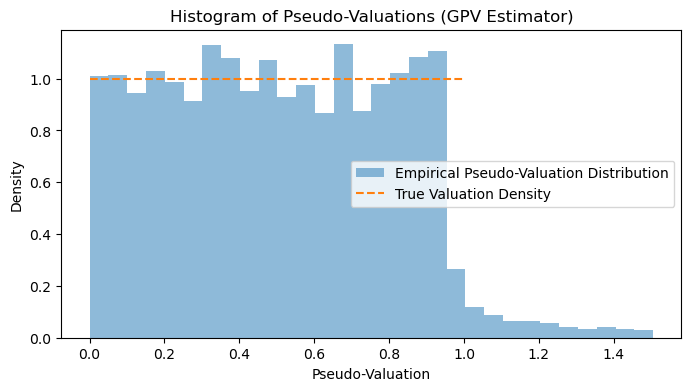

In [23]:
plt.figure(figsize=(8, 4))
plt.hist(pseudo_vals, bins=30, density=True, alpha=0.5, label='Empirical Pseudo-Valuation Distribution')
x_val = np.linspace(0, 1, 1000)
true_v_pdf = uniform.pdf(x_val, loc=0, scale=1)
plt.plot(x_val, true_v_pdf, linestyle='--', label='True Valuation Density')
plt.xlabel('Pseudo-Valuation')
plt.ylabel('Density')
plt.title('Histogram of Pseudo-Valuations (GPV Estimator)')
plt.legend()
plt.show()

In [18]:
bandwidth_pv = scott_rule(pseudo_vals)
pv_pdf = kde_sklearn(pseudo_vals, x_val, bandwidth=bandwidth_pv, kernel='epanechnikov')

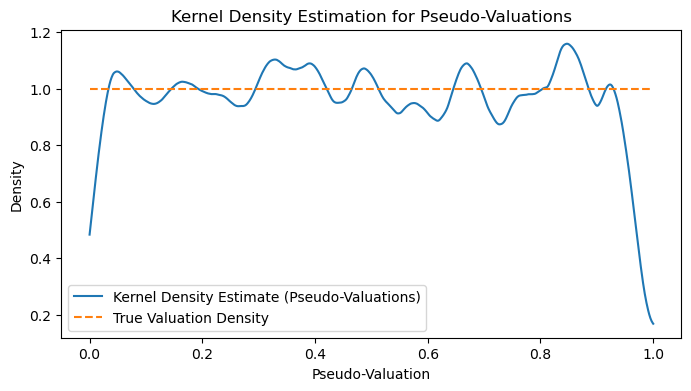

In [19]:
plt.figure(figsize=(8, 4))
plt.plot(x_val, pv_pdf, label='Kernel Density Estimate (Pseudo-Valuations)')
plt.plot(x_val, true_v_pdf, linestyle='--', label='True Valuation Density')
plt.xlabel('Pseudo-Valuation')
plt.ylabel('Density')
plt.title('Kernel Density Estimation for Pseudo-Valuations')
plt.legend()
plt.show()

In [20]:
ecdf_pv = ECDF(pseudo_vals)
pv_cdf = ecdf_pv(x_val)


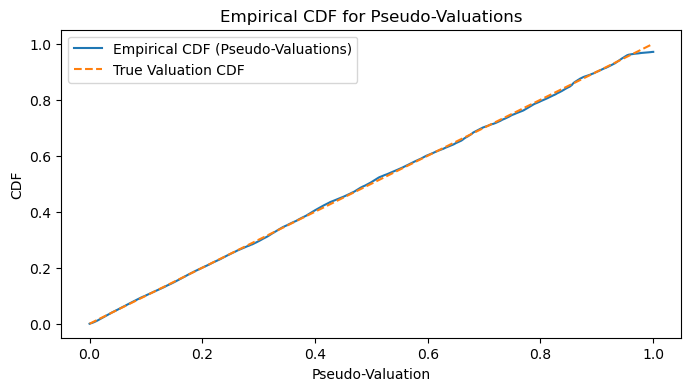

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(x_val, pv_cdf, label='Empirical CDF (Pseudo-Valuations)')
true_v_cdf = uniform.cdf(x_val, loc=0, scale=1)
plt.plot(x_val, true_v_cdf, linestyle='--', label='True Valuation CDF')
plt.xlabel('Pseudo-Valuation')
plt.ylabel('CDF')
plt.title('Empirical CDF for Pseudo-Valuations')
plt.legend()
plt.show()